# **Homework 10 - Adversarial Attack**

Slides: https://reurl.cc/7DDxnD

Contact: ntu-ml-2022spring-ta@googlegroups.com


## Enviroment & Download

We make use of [pytorchcv](https://pypi.org/project/pytorchcv/) to obtain CIFAR-10 pretrained model, so we need to set up the enviroment first. We also need to download the data (200 images) which we want to attack.

In [ ]:
# set up environment
!pip install pytorchcv
!pip install imgaug

# download
!wget https://github.com/DanielLin94144/ML-attack-dataset/files/8167812/data.zip

# unzip
!unzip ./data.zip
!rm ./data.zip

In [1]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 4

## Global Settings 
#### **[NOTE]**: Don't change the settings here, or your generated image might not meet the constraint.
* $\epsilon$ is fixed to be 8. But on **Data section**, we will first apply transforms on raw pixel value (0-255 scale) **by ToTensor (to 0-1 scale)** and then **Normalize (subtract mean divide std)**. $\epsilon$ should be set to $\frac{8}{255 * std}$ during attack.

* Explaination (optional)
    * Denote the first pixel of original image as $p$, and the first pixel of adversarial image as $a$.
    * The $\epsilon$ constraints tell us $\left| p-a \right| <= 8$.
    * ToTensor() can be seen as a function where $T(x) = x/255$.
    * Normalize() can be seen as a function where $N(x) = (x-mean)/std$ where $mean$ and $std$ are constants.
    * After applying ToTensor() and Normalize() on $p$ and $a$, the constraint becomes $\left| N(T(p))-N(T(a)) \right| = \left| \frac{\frac{p}{255}-mean}{std}-\frac{\frac{a}{255}-mean}{std} \right| = \frac{1}{255 * std} \left| p-a \right| <= \frac{8}{255 * std}.$
    * So, we should set $\epsilon$ to be $\frac{8}{255 * std}$ after ToTensor() and Normalize().

In [2]:
# the mean and std are the calculated statistics from cifar_10 dataset
cifar_10_mean = (0.491, 0.482, 0.447)   # mean for the three channels of cifar_10 images
cifar_10_std = (0.202, 0.199, 0.201)    # std for the three channels of cifar_10 images

# convert mean and std to 3-dimensional tensors for future operations
mean = torch.tensor(cifar_10_mean).to(device).view(3, 1, 1)
std = torch.tensor(cifar_10_std).to(device).view(3, 1, 1)

epsilon = 8/255/std

In [3]:
root = './data' # directory for storing benign images
# benign images: images which do not contain adversarial perturbations
# adversarial images: images which include adversarial perturbations

## Data

Construct dataset and dataloader from root directory. Note that we store the filename of each image for future usage.

In [4]:
import random
import os
import glob
import shutil
import numpy as np
from tqdm import tqdm
from PIL import Image
from torchvision.transforms import transforms
from torchvision.transforms import InterpolationMode
import torchvision.transforms.functional as F
from pytorchcv.model_provider import get_model as ptcv_get_model
from torch.utils.data import Dataset, DataLoader

def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(48763)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_10_mean, cifar_10_std)
])


class AdvDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.images = []
        self.labels = []
        self.names = []
        '''
        data_dir
        ├── class_dir
        │   ├── class1.png
        │   ├── ...
        │   ├── class20.png
        '''
        for i, class_dir in enumerate(sorted(glob.glob(f'{data_dir}/*'))):
            images = sorted(glob.glob(f'{class_dir}/*'))
            self.images += images
            self.labels += ([i] * len(images))
            self.names += [os.path.relpath(imgs, data_dir) for imgs in images]
        self.transform = transform
    def __getitem__(self, idx):
        image = self.transform(Image.open(self.images[idx]))
        label = self.labels[idx]
        return image, label
    def __getname__(self):
        return self.names
    def __len__(self):
        return len(self.images)

adv_set = AdvDataset(root, transform=transform)
adv_names = adv_set.__getname__()
adv_loader = DataLoader(adv_set, batch_size=batch_size, shuffle=False, num_workers=8)

print(f'number of images = {adv_set.__len__()}')

number of images = 200


## Utils -- Benign Images Evaluation

In [5]:
# to evaluate the performance of model on benign images
def epoch_benign(model, loader, loss_fn):
    model.eval()
    train_acc, train_loss = 0.0, 0.0
    for x, y in tqdm(loader):
        x, y = x.to(device), y.to(device)
        yp = model(x)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
    return train_acc / len(loader.dataset), train_loss / len(loader.dataset)

## Utils -- Attack Algorithm

In [6]:
# perform fgsm attack
def fgsm(model, x, y, loss_fn, epsilon=epsilon):
    x_adv = x.detach().clone() # initialize x_adv as original benign image x
    x_adv.requires_grad = True # need to obtain gradient of x_adv, thus set required grad
    loss = loss_fn(model(x_adv), y) # calculate loss
    loss.backward() # calculate gradient
    # fgsm: use gradient ascent on x_adv to maximize loss
    grad = x_adv.grad.detach()
    x_adv = x_adv + epsilon * grad.sign()
    return x_adv

# alpha and num_iter can be decided by yourself
alpha = 0.8/255/std
def ifgsm(model, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=20):
    x_adv = x
    # write a loop of num_iter to represent the iterative times
    for i in range(num_iter):
        # x_adv = fgsm(model, x_adv, y, loss_fn, alpha) # call fgsm with (epsilon = alpha) to obtain new x_adv
        x_adv = x_adv.detach().clone()
        x_adv.requires_grad = True # need to obtain gradient of x_adv, thus set required grad
        loss = loss_fn(model(x_adv), y) # calculate loss
        loss.backward() # calculate gradient
        # fgsm: use gradient ascent on x_adv to maximize loss
        grad = x_adv.grad.detach()
        x_adv = x_adv + alpha * grad.sign()

        x_adv = torch.max(torch.min(x_adv, x+epsilon), x-epsilon) # clip new x_adv back to [x-epsilon, x+epsilon]
    return x_adv

def mifgsm(model, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=20, decay=1.0):
    x_adv = x
    # initialze momentum tensor
    momentum = torch.zeros_like(x).detach().to(device)
    # write a loop of num_iter to represent the iterative times
    for i in range(num_iter):
        x_adv = x_adv.detach().clone()
        x_adv.requires_grad = True # need to obtain gradient of x_adv, thus set required grad
        loss = loss_fn(model(x_adv), y) # calculate loss
        loss.backward() # calculate gradient
        # TODO: Momentum calculation
        grad = x_adv.grad.detach()
        grad = decay * momentum + (x_adv.grad / x_adv.grad.norm(1, dim=[1, 2, 3], keepdim=True))
        momentum = grad
        x_adv = x_adv + alpha * grad.sign()
        x_adv = torch.max(torch.min(x_adv, x+epsilon), x-epsilon) # clip new x_adv back to [x-epsilon, x+epsilon]
    return x_adv

def dimmifgsm(model, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=20, decay=1.0, prob=0.5):
    image_size = x.size(3)      # Image's Height
    # Do random crop and random padding
    if random.random() < prob:
        resize = int(random.uniform(16, image_size))
        pad_top = int(random.uniform(0, image_size - resize))
        pad_bottom = image_size - resize - pad_top
        pad_left = int(random.uniform(0, image_size - resize))
        pad_right = image_size - resize - pad_left
        x_adv = F.resize(x, size=resize, interpolation=InterpolationMode.NEAREST)
        x_adv = F.pad(x_adv, padding=[pad_left, pad_top, pad_right, pad_bottom], fill=0, padding_mode='constant')
    else:
        x_adv = x
    # initialze momentum tensor
    momentum = torch.zeros_like(x).detach().to(device)
    # write a loop of num_iter to represent the iterative times
    for i in range(num_iter):
        x_adv = x_adv.detach().clone()
        x_adv.requires_grad = True # need to obtain gradient of x_adv, thus set required grad
        loss = loss_fn(model(x_adv), y) # calculate loss
        loss.backward() # calculate gradient
        # TODO: Momentum calculation
        grad = x_adv.grad.detach()
        grad = decay * momentum + (x_adv.grad / x_adv.grad.norm(1, dim=[1, 2, 3], keepdim=True))        # Get normalized gradient
        momentum = grad
        x_adv = x_adv + alpha * grad.sign()
        x_adv = torch.max(torch.min(x_adv, x+epsilon), x-epsilon) # clip new x_adv back to [x-epsilon, x+epsilon]
    return x_adv

## Utils -- Attack
* Recall
  * ToTensor() can be seen as a function where $T(x) = x/255$.
  * Normalize() can be seen as a function where $N(x) = (x-mean)/std$ where $mean$ and $std$ are constants.

* Inverse function
  * Inverse Normalize() can be seen as a function where $N^{-1}(x) = x*std+mean$ where $mean$ and $std$ are constants.
  * Inverse ToTensor() can be seen as a function where $T^{-1}(x) = x*255$.

* Special Noted
  * ToTensor() will also convert the image from shape (height, width, channel) to shape (channel, height, width), so we also need to transpose the shape back to original shape.
  * Since our dataloader samples a batch of data, what we need here is to transpose **(batch_size, channel, height, width)** back to **(batch_size, height, width, channel)** using np.transpose.

In [7]:
# perform adversarial attack and generate adversarial examples
def gen_adv_examples(model, loader, attack, loss_fn):
    model.eval()
    # adv_names = []
    train_acc, train_loss = 0.0, 0.0
    for i, (x, y) in enumerate(tqdm(loader)):
        x, y = x.to(device), y.to(device)
        x_adv = attack(model, x, y, loss_fn) # obtain adversarial examples
        yp = model(x_adv)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
        # store adversarial examples
        adv_ex = ((x_adv) * std + mean).clamp(0, 1) # to 0-1 scale
        adv_ex = (adv_ex * 255).clamp(0, 255) # 0-255 scale
        adv_ex = adv_ex.detach().cpu().data.numpy().round() # round to remove decimal part
        adv_ex = adv_ex.transpose((0, 2, 3, 1)) # transpose (bs, C, H, W) back to (bs, H, W, C)
        adv_examples = adv_ex if i == 0 else np.r_[adv_examples, adv_ex]
    return adv_examples, train_acc / len(loader.dataset), train_loss / len(loader.dataset)

# create directory which stores adversarial examples
def create_dir(data_dir, adv_dir, adv_examples, adv_names):
    if os.path.exists(adv_dir) is not True:
        _ = shutil.copytree(data_dir, adv_dir)
    for example, name in zip(adv_examples, adv_names):
        im = Image.fromarray(example.astype(np.uint8)) # image pixel value should be unsigned int
        im.save(os.path.join(adv_dir, name))

## Model / Loss Function

Model list is available [here](https://github.com/osmr/imgclsmob/blob/master/pytorch/pytorchcv/model_provider.py). Please select models which has _cifar10 suffix. Some of the models cannot be accessed/loaded. You can safely skip them since TA's model will not use those kinds of models.

In [8]:
# Available models for CIFAR-10
model_list = [
    'nin_cifar10',
    'resnet20_cifar10',
    'resnet56_cifar10',
    'resnet110_cifar10',
    'resnet164bn_cifar10',
    'resnet272bn_cifar10',
    'resnet542bn_cifar10',
    'resnet1001_cifar10',
    'resnet1202_cifar10',
    'preresnet20_cifar10',
    'preresnet56_cifar10',
    'preresnet110_cifar10',
    'preresnet164bn_cifar10',
    'preresnet272bn_cifar10',
    'preresnet542bn_cifar10',
    'preresnet1001_cifar10',
    'preresnet1202_cifar10',
    'resnext20_16x4d_cifar10',
    'resnext20_32x2d_cifar10',
    'resnext20_32x4d_cifar10',
    'resnext29_32x4d_cifar10',
    'resnext29_16x64d_cifar10',
    'resnext272_1x64d_cifar10',
    'resnext272_2x32d_cifar10',
    'seresnet20_cifar10',
    'seresnet56_cifar10',
    'seresnet110_cifar10',
    'seresnet164bn_cifar10',
    'seresnet272bn_cifar10',
    'seresnet542bn_cifar10',
    'seresnet1001_cifar10',
    'seresnet1202_cifar10',
    'sepreresnet20_cifar10',
    'sepreresnet56_cifar10',
    'sepreresnet110_cifar10',
    'sepreresnet164bn_cifar10',
    'sepreresnet272bn_cifar10',
    'sepreresnet542bn_cifar10',
    'sepreresnet1001_cifar10',
    'sepreresnet1202_cifar10',
    'pyramidnet110_a48_cifar10',
    'pyramidnet110_a84_cifar10',
    'pyramidnet110_a270_cifar10',
    'pyramidnet164_a270_bn_cifar10',
    'pyramidnet200_a240_bn_cifar10',
    'pyramidnet236_a220_bn_cifar10',
    'pyramidnet272_a200_bn_cifar10',
    'densenet40_k12_cifar10',
    'densenet40_k12_bc_cifar10',
    'densenet40_k24_bc_cifar10',
    'densenet40_k36_bc_cifar10',
    'densenet100_k12_cifar10',
    'densenet100_k24_cifar10',
    'densenet100_k12_bc_cifar10',
    'densenet190_k40_bc_cifar10',
    'densenet250_k24_bc_cifar10',
    'xdensenet40_2_k24_bc_cifar10',
    'xdensenet40_2_k36_bc_cifar10',
    'wrn16_10_cifar10',
    'wrn28_10_cifar10',
    'wrn40_8_cifar10',
    'wrn20_10_1bit_cifar10',
    'wrn20_10_32bit_cifar10',
    'ror3_56_cifar10',
    'ror3_110_cifar10',
    'ror3_164_cifar10',
    'rir_cifar10',
    'msdnet22_cifar10',
    'resdropresnet20_cifar10',
    'shakeshakeresnet20_2x16d_cifar10',
    'shakeshakeresnet26_2x32d_cifar10',
    'shakedropresnet20_cifar10',
    'fractalnet_cifar10',
    'diaresnet20_cifar10',
    'diaresnet56_cifar10',
    'diaresnet110_cifar10',
    'diaresnet164bn_cifar10',
    'diaresnet1001_cifar10',
    'diaresnet1202_cifar10',
    'diapreresnet20_cifar10',
    'diapreresnet56_cifar10',
    'diapreresnet110_cifar10',
    'diapreresnet164bn_cifar10',
    'diapreresnet1001_cifar10',
    'diapreresnet1202_cifar10',
]

In [9]:
history = {}

for model_name in model_list:
    try:
        model = ptcv_get_model(model_name, pretrained=True).to(device)
        loss_fn = nn.CrossEntropyLoss()

        benign_acc, benign_loss = epoch_benign(model, adv_loader, loss_fn)
        record = {'acc': benign_acc, 'loss': benign_loss}
        history[model_name] = record
        model_name = model_name.ljust(35, ' ')
        print(f'[INFO] {model_name}: benign_acc = {benign_acc:.5f}, benign_loss = {benign_loss:.5f}') 
        del model
    except:
        pass

100%|██████████| 50/50 [00:00<00:00, 89.80it/s] 


[INFO] nin_cifar10                        : benign_acc = 0.91500, benign_loss = 0.30363


100%|██████████| 50/50 [00:00<00:00, 81.32it/s]


[INFO] resnet20_cifar10                   : benign_acc = 0.94500, benign_loss = 0.17511


100%|██████████| 50/50 [00:00<00:00, 56.15it/s]


[INFO] resnet56_cifar10                   : benign_acc = 0.95000, benign_loss = 0.16542


100%|██████████| 50/50 [00:01<00:00, 37.54it/s]


[INFO] resnet110_cifar10                  : benign_acc = 0.95000, benign_loss = 0.22685


100%|██████████| 50/50 [00:01<00:00, 32.83it/s]


[INFO] resnet164bn_cifar10                : benign_acc = 0.96000, benign_loss = 0.29925


100%|██████████| 50/50 [00:02<00:00, 22.27it/s]


[INFO] resnet272bn_cifar10                : benign_acc = 0.97000, benign_loss = 0.17874


100%|██████████| 50/50 [00:03<00:00, 12.64it/s]


[INFO] resnet542bn_cifar10                : benign_acc = 0.95500, benign_loss = 0.19708


100%|██████████| 50/50 [00:07<00:00,  7.10it/s]


[INFO] resnet1001_cifar10                 : benign_acc = 0.96500, benign_loss = 0.16739


100%|██████████| 50/50 [00:10<00:00,  4.84it/s]


[INFO] resnet1202_cifar10                 : benign_acc = 0.97000, benign_loss = 0.17800


100%|██████████| 50/50 [00:00<00:00, 81.22it/s]


[INFO] preresnet20_cifar10                : benign_acc = 0.94500, benign_loss = 0.18539


100%|██████████| 50/50 [00:00<00:00, 52.53it/s]


[INFO] preresnet56_cifar10                : benign_acc = 0.96000, benign_loss = 0.12400


100%|██████████| 50/50 [00:01<00:00, 36.26it/s]


[INFO] preresnet110_cifar10               : benign_acc = 0.95000, benign_loss = 0.28517


100%|██████████| 50/50 [00:01<00:00, 32.10it/s]


[INFO] preresnet164bn_cifar10             : benign_acc = 0.96000, benign_loss = 0.17446


100%|██████████| 50/50 [00:02<00:00, 22.74it/s]


[INFO] preresnet272bn_cifar10             : benign_acc = 0.96500, benign_loss = 0.17147


100%|██████████| 50/50 [00:04<00:00, 12.50it/s]


[INFO] preresnet542bn_cifar10             : benign_acc = 0.98000, benign_loss = 0.09917


100%|██████████| 50/50 [00:07<00:00,  7.07it/s]


[INFO] preresnet1001_cifar10              : benign_acc = 0.97500, benign_loss = 0.18579


100%|██████████| 50/50 [00:10<00:00,  4.91it/s]


[INFO] preresnet1202_cifar10              : benign_acc = 0.97000, benign_loss = 0.15597


100%|██████████| 50/50 [00:00<00:00, 67.98it/s] 


[INFO] resnext29_32x4d_cifar10            : benign_acc = 0.95500, benign_loss = 0.15147


100%|██████████| 50/50 [00:00<00:00, 59.26it/s]


[INFO] resnext29_16x64d_cifar10           : benign_acc = 0.95000, benign_loss = 0.25942


100%|██████████| 50/50 [00:02<00:00, 17.10it/s]


[INFO] resnext272_1x64d_cifar10           : benign_acc = 0.97500, benign_loss = 0.11048


100%|██████████| 50/50 [00:03<00:00, 15.30it/s]


[INFO] resnext272_2x32d_cifar10           : benign_acc = 0.97000, benign_loss = 0.12666


100%|██████████| 50/50 [00:00<00:00, 68.96it/s]


[INFO] seresnet20_cifar10                 : benign_acc = 0.93000, benign_loss = 0.23977


100%|██████████| 50/50 [00:01<00:00, 41.37it/s]


[INFO] seresnet56_cifar10                 : benign_acc = 0.96500, benign_loss = 0.13968


100%|██████████| 50/50 [00:01<00:00, 26.21it/s]


[INFO] seresnet110_cifar10                : benign_acc = 0.95500, benign_loss = 0.27535


100%|██████████| 50/50 [00:02<00:00, 22.87it/s]


[INFO] seresnet164bn_cifar10              : benign_acc = 0.97000, benign_loss = 0.27514


100%|██████████| 50/50 [00:03<00:00, 14.70it/s]


[INFO] seresnet272bn_cifar10              : benign_acc = 0.97500, benign_loss = 0.13301


100%|██████████| 50/50 [00:06<00:00,  8.13it/s]


[INFO] seresnet542bn_cifar10              : benign_acc = 0.96500, benign_loss = 0.16029


100%|██████████| 50/50 [00:00<00:00, 69.12it/s]


[INFO] sepreresnet20_cifar10              : benign_acc = 0.95000, benign_loss = 0.22251


100%|██████████| 50/50 [00:01<00:00, 41.68it/s]


[INFO] sepreresnet56_cifar10              : benign_acc = 0.95000, benign_loss = 0.28767


100%|██████████| 50/50 [00:01<00:00, 26.18it/s]


[INFO] sepreresnet110_cifar10             : benign_acc = 0.96500, benign_loss = 0.27380


100%|██████████| 50/50 [00:02<00:00, 22.07it/s]


[INFO] sepreresnet164bn_cifar10           : benign_acc = 0.95500, benign_loss = 0.16938


100%|██████████| 50/50 [00:03<00:00, 14.74it/s]


[INFO] sepreresnet272bn_cifar10           : benign_acc = 0.96000, benign_loss = 0.16116


100%|██████████| 50/50 [00:06<00:00,  8.17it/s]


[INFO] sepreresnet542bn_cifar10           : benign_acc = 0.97500, benign_loss = 0.15848


100%|██████████| 50/50 [00:01<00:00, 30.25it/s]


[INFO] pyramidnet110_a48_cifar10          : benign_acc = 0.96000, benign_loss = 0.17970


100%|██████████| 50/50 [00:01<00:00, 28.39it/s]


[INFO] pyramidnet110_a84_cifar10          : benign_acc = 0.95500, benign_loss = 0.25727


100%|██████████| 50/50 [00:01<00:00, 27.74it/s]


[INFO] pyramidnet110_a270_cifar10         : benign_acc = 0.97000, benign_loss = 0.14473


100%|██████████| 50/50 [00:02<00:00, 23.14it/s]


[INFO] pyramidnet164_a270_bn_cifar10      : benign_acc = 0.96000, benign_loss = 0.18992


100%|██████████| 50/50 [00:02<00:00, 19.88it/s]


[INFO] pyramidnet200_a240_bn_cifar10      : benign_acc = 0.97500, benign_loss = 0.12544


100%|██████████| 50/50 [00:02<00:00, 17.73it/s]


[INFO] pyramidnet236_a220_bn_cifar10      : benign_acc = 0.96500, benign_loss = 0.14341


100%|██████████| 50/50 [00:03<00:00, 15.75it/s]


[INFO] pyramidnet272_a200_bn_cifar10      : benign_acc = 0.96000, benign_loss = 0.19547


100%|██████████| 50/50 [00:01<00:00, 49.38it/s]


[INFO] densenet40_k12_cifar10             : benign_acc = 0.93000, benign_loss = 0.23954


100%|██████████| 50/50 [00:00<00:00, 65.31it/s]


[INFO] densenet40_k12_bc_cifar10          : benign_acc = 0.93000, benign_loss = 0.23472


100%|██████████| 50/50 [00:00<00:00, 60.79it/s]


[INFO] densenet40_k24_bc_cifar10          : benign_acc = 0.94000, benign_loss = 0.20853


100%|██████████| 50/50 [00:00<00:00, 53.17it/s]


[INFO] densenet40_k36_bc_cifar10          : benign_acc = 0.95500, benign_loss = 0.25788


100%|██████████| 50/50 [00:01<00:00, 28.78it/s]


[INFO] densenet100_k12_cifar10            : benign_acc = 0.96000, benign_loss = 0.28854


100%|██████████| 50/50 [00:01<00:00, 32.85it/s]


[INFO] densenet100_k24_cifar10            : benign_acc = 0.96500, benign_loss = 0.14940


100%|██████████| 50/50 [00:01<00:00, 37.75it/s]


[INFO] densenet100_k12_bc_cifar10         : benign_acc = 0.95500, benign_loss = 0.34458


100%|██████████| 50/50 [00:02<00:00, 16.86it/s]


[INFO] densenet190_k40_bc_cifar10         : benign_acc = 0.95500, benign_loss = 0.21167


100%|██████████| 50/50 [00:03<00:00, 16.45it/s]


[INFO] densenet250_k24_bc_cifar10         : benign_acc = 0.96500, benign_loss = 0.18242


100%|██████████| 50/50 [00:00<00:00, 59.03it/s]


[INFO] xdensenet40_2_k24_bc_cifar10       : benign_acc = 0.94000, benign_loss = 0.24839


100%|██████████| 50/50 [00:00<00:00, 52.53it/s]


[INFO] xdensenet40_2_k36_bc_cifar10       : benign_acc = 0.94500, benign_loss = 0.30897


100%|██████████| 50/50 [00:00<00:00, 81.72it/s]


[INFO] wrn16_10_cifar10                   : benign_acc = 0.95000, benign_loss = 0.15858


100%|██████████| 50/50 [00:00<00:00, 67.03it/s]


[INFO] wrn28_10_cifar10                   : benign_acc = 0.96000, benign_loss = 0.17570


100%|██████████| 50/50 [00:00<00:00, 57.82it/s]


[INFO] wrn40_8_cifar10                    : benign_acc = 0.98000, benign_loss = 0.21565


100%|██████████| 50/50 [00:00<00:00, 69.42it/s]


[INFO] wrn20_10_1bit_cifar10              : benign_acc = 0.96000, benign_loss = 0.12562


100%|██████████| 50/50 [00:00<00:00, 71.59it/s]


[INFO] wrn20_10_32bit_cifar10             : benign_acc = 0.97000, benign_loss = 0.20011


100%|██████████| 50/50 [00:00<00:00, 54.79it/s]


[INFO] ror3_56_cifar10                    : benign_acc = 0.95000, benign_loss = 0.24275


100%|██████████| 50/50 [00:01<00:00, 37.09it/s]


[INFO] ror3_110_cifar10                   : benign_acc = 0.95500, benign_loss = 0.28892


100%|██████████| 50/50 [00:01<00:00, 26.96it/s]


[INFO] ror3_164_cifar10                   : benign_acc = 0.96000, benign_loss = 0.18171


100%|██████████| 50/50 [00:01<00:00, 43.78it/s]


[INFO] rir_cifar10                        : benign_acc = 0.97000, benign_loss = 0.14603


100%|██████████| 50/50 [00:00<00:00, 60.67it/s]


[INFO] shakeshakeresnet20_2x16d_cifar10   : benign_acc = 0.94000, benign_loss = 0.18736


100%|██████████| 50/50 [00:00<00:00, 51.75it/s]


[INFO] shakeshakeresnet26_2x32d_cifar10   : benign_acc = 0.96500, benign_loss = 0.12388


100%|██████████| 50/50 [00:00<00:00, 62.96it/s]


[INFO] diaresnet20_cifar10                : benign_acc = 0.93000, benign_loss = 0.36155


100%|██████████| 50/50 [00:01<00:00, 36.09it/s]


[INFO] diaresnet56_cifar10                : benign_acc = 0.95500, benign_loss = 0.19110


100%|██████████| 50/50 [00:02<00:00, 21.34it/s]


[INFO] diaresnet110_cifar10               : benign_acc = 0.96500, benign_loss = 0.20180


100%|██████████| 50/50 [00:02<00:00, 20.19it/s]


[INFO] diaresnet164bn_cifar10             : benign_acc = 0.97000, benign_loss = 0.13041


100%|██████████| 50/50 [00:00<00:00, 64.56it/s]


[INFO] diapreresnet20_cifar10             : benign_acc = 0.93500, benign_loss = 0.20088


100%|██████████| 50/50 [00:01<00:00, 35.41it/s]


[INFO] diapreresnet56_cifar10             : benign_acc = 0.94000, benign_loss = 0.15835


100%|██████████| 50/50 [00:02<00:00, 21.92it/s]


[INFO] diapreresnet110_cifar10            : benign_acc = 0.94500, benign_loss = 0.20751


100%|██████████| 50/50 [00:02<00:00, 19.84it/s]


[INFO] diapreresnet164bn_cifar10          : benign_acc = 0.96000, benign_loss = 0.15617


In [10]:
# Sort the result by accuracy
sorted_history = dict(sorted(history.items(), key = lambda x: x[1]['acc'], reverse=True))
sorted_history

{'preresnet542bn_cifar10': {'acc': 0.98, 'loss': 0.09917429255787283},
 'wrn40_8_cifar10': {'acc': 0.98, 'loss': 0.2156474009156227},
 'preresnet1001_cifar10': {'acc': 0.975, 'loss': 0.18579362001270056},
 'resnext272_1x64d_cifar10': {'acc': 0.975, 'loss': 0.1104794073337689},
 'seresnet272bn_cifar10': {'acc': 0.975, 'loss': 0.1330104276072234},
 'sepreresnet542bn_cifar10': {'acc': 0.975, 'loss': 0.15847624632529914},
 'pyramidnet200_a240_bn_cifar10': {'acc': 0.975, 'loss': 0.12543588397325947},
 'resnet272bn_cifar10': {'acc': 0.97, 'loss': 0.17874206649605184},
 'resnet1202_cifar10': {'acc': 0.97, 'loss': 0.17800311758648604},
 'preresnet1202_cifar10': {'acc': 0.97, 'loss': 0.15596881506964563},
 'resnext272_2x32d_cifar10': {'acc': 0.97, 'loss': 0.12665705977706238},
 'seresnet164bn_cifar10': {'acc': 0.97, 'loss': 0.275142517387867},
 'pyramidnet110_a270_cifar10': {'acc': 0.97, 'loss': 0.144725624518469},
 'wrn20_10_32bit_cifar10': {'acc': 0.97, 'loss': 0.20010990306735038},
 'rir_cif

## FGSM

In [11]:
model = ptcv_get_model('resnet110_cifar10', pretrained=True).to(device)
loss_fn = nn.CrossEntropyLoss()
adv_examples, fgsm_acc, fgsm_loss = gen_adv_examples(model, adv_loader, fgsm, loss_fn)
print(f'fgsm_acc = {fgsm_acc:.5f}, fgsm_loss = {fgsm_loss:.5f}')

create_dir(root, 'fgsm', adv_examples, adv_names)

100%|██████████| 50/50 [00:03<00:00, 14.75it/s]

fgsm_acc = 0.58500, fgsm_loss = 2.48103


## I-FGSM

In [12]:
model = ptcv_get_model('resnet110_cifar10', pretrained=True).to(device)
loss_fn = nn.CrossEntropyLoss()
adv_examples, ifgsm_acc, ifgsm_loss = gen_adv_examples(model, adv_loader, ifgsm, loss_fn)
print(f'ifgsm_acc = {ifgsm_acc:.5f}, ifgsm_loss = {ifgsm_loss:.5f}')

create_dir(root, 'ifgsm', adv_examples, adv_names)

100%|██████████| 50/50 [00:39<00:00,  1.26it/s]

ifgsm_acc = 0.01500, ifgsm_loss = 14.78773


## MI-FGSM

In [13]:
model = ptcv_get_model('resnet110_cifar10', pretrained=True).to(device)
loss_fn = nn.CrossEntropyLoss()
adv_examples, ifgsm_acc, ifgsm_loss = gen_adv_examples(model, adv_loader, mifgsm, loss_fn)
print(f'mifgsm_acc = {ifgsm_acc:.5f}, mifgsm_loss = {ifgsm_loss:.5f}')

create_dir(root, 'mifgsm', adv_examples, adv_names)

100%|██████████| 50/50 [00:40<00:00,  1.24it/s]

mifgsm_acc = 0.03000, mifgsm_loss = 11.12591


## Compress the images
* Submit the .tgz file to [JudgeBoi](https://ml.ee.ntu.edu.tw/hw10/)

In [14]:
# %cd fgsm
# !tar zcvf ../fgsm.tgz *
# %cd ..

# %cd ifgsm
# !tar zcvf ../ifgsm.tgz *
# %cd ..

# %cd mifgsm
# !tar zcvf ../mifgsm.tgz *
# %cd ..

/home/tienyi/Machine Learning/HW10/fgsm
airplane/
airplane/airplane9.png
airplane/airplane3.png
airplane/airplane11.png
airplane/airplane10.png
airplane/airplane5.png
airplane/airplane20.png
airplane/airplane15.png
airplane/airplane14.png
airplane/airplane17.png
airplane/airplane18.png
airplane/airplane8.png
airplane/airplane16.png
airplane/airplane12.png
airplane/airplane1.png
airplane/airplane6.png
airplane/airplane13.png
airplane/airplane4.png
airplane/airplane7.png
airplane/airplane19.png
airplane/airplane2.png
automobile/
automobile/automobile11.png
automobile/automobile13.png
automobile/automobile5.png
automobile/automobile9.png
automobile/automobile6.png
automobile/automobile15.png
automobile/automobile3.png
automobile/automobile20.png
automobile/automobile2.png
automobile/automobile1.png
automobile/automobile4.png
automobile/automobile10.png
automobile/automobile14.png
automobile/automobile16.png
automobile/automobile12.png
automobile/automobile8.png
automobile/automobile19.png

## Example of Ensemble Attack
* Ensemble multiple models as your proxy model to increase the black-box transferability ([paper](https://arxiv.org/abs/1611.02770))

In [8]:
class ensembleNet(nn.Module):
    def __init__(self, model_names):
        super().__init__()
        self.models = nn.ModuleList([ptcv_get_model(name, pretrained=True) for name in model_names])
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        ensemble_logits = []
        for i, m in enumerate(self.models):
        # TODO: sum up logits from multiple models
            ensemble_logits.append(m(x))
        ensemble_logits = torch.cat(ensemble_logits, axis=0)
        ensemble_logits = ensemble_logits.reshape((len(self.models), batch_size, -1)).mean(dim=0)
        return ensemble_logits

* Construct your ensemble model

In [9]:
from pytorchcv.model_provider import get_model as ptcv_get_model
model_names = [
    # 'nin_cifar10',
    'resnet20_cifar10',
    'resnet56_cifar10',
    'resnet110_cifar10',
    'resnet164bn_cifar10',
    'resnet272bn_cifar10',
    'resnet542bn_cifar10',
    'resnet1001_cifar10',
    'resnet1202_cifar10',
    # 'preresnet20_cifar10',
    # 'preresnet56_cifar10',
    # 'preresnet110_cifar10',
    # 'preresnet164bn_cifar10',
    # 'preresnet272bn_cifar10',
    # 'preresnet542bn_cifar10',
    # 'preresnet1001_cifar10',
    # 'preresnet1202_cifar10',
    # 'resnext20_16x4d_cifar10',
    # 'resnext20_32x2d_cifar10',
    # 'resnext20_32x4d_cifar10',
    # 'resnext29_32x4d_cifar10',
    # 'resnext29_16x64d_cifar10',
    'resnext272_1x64d_cifar10',
    'resnext272_2x32d_cifar10',
    'seresnet20_cifar10',
    'seresnet56_cifar10',
    'seresnet110_cifar10',
    'seresnet164bn_cifar10',
    'seresnet272bn_cifar10',
    'seresnet542bn_cifar10',
    # 'seresnet1001_cifar10',
    # 'seresnet1202_cifar10',
    # 'sepreresnet20_cifar10',
    # 'sepreresnet56_cifar10',
    # 'sepreresnet110_cifar10',
    # 'sepreresnet164bn_cifar10',
    # 'sepreresnet272bn_cifar10',
    # 'sepreresnet542bn_cifar10',
    # 'sepreresnet1001_cifar10',
    # 'sepreresnet1202_cifar10',
    # 'pyramidnet110_a48_cifar10',
    # 'pyramidnet110_a84_cifar10',
    # 'pyramidnet110_a270_cifar10',
    # 'pyramidnet164_a270_bn_cifar10',
    # 'pyramidnet200_a240_bn_cifar10',
    # 'pyramidnet236_a220_bn_cifar10',
    # 'pyramidnet272_a200_bn_cifar10',
    'densenet40_k12_cifar10',
    'densenet40_k12_bc_cifar10',
    'densenet40_k24_bc_cifar10',
    'densenet40_k36_bc_cifar10',
    'densenet100_k12_cifar10',
    'densenet100_k24_cifar10',
    'densenet100_k12_bc_cifar10',
    'densenet190_k40_bc_cifar10',
    'densenet250_k24_bc_cifar10',
    # 'xdensenet40_2_k24_bc_cifar10',
    # 'xdensenet40_2_k36_bc_cifar10',
    # 'wrn16_10_cifar10',
    # 'wrn28_10_cifar10',
    # 'wrn40_8_cifar10',
    # 'wrn20_10_1bit_cifar10',
    # 'wrn20_10_32bit_cifar10',
    # 'ror3_56_cifar10',
    # 'ror3_110_cifar10',
    # 'ror3_164_cifar10',
    # 'rir_cifar10',
    # 'msdnet22_cifar10',
    # 'resdropresnet20_cifar10',
    # 'shakeshakeresnet20_2x16d_cifar10',
    # 'shakeshakeresnet26_2x32d_cifar10',
    # 'shakedropresnet20_cifar10',
    # 'fractalnet_cifar10',
    # 'diaresnet20_cifar10',
    # 'diaresnet56_cifar10',
    # 'diaresnet110_cifar10',
    # 'diaresnet164bn_cifar10',
    # 'diaresnet1001_cifar10',
    # 'diaresnet1202_cifar10',
    # 'diapreresnet20_cifar10',
    # 'diapreresnet56_cifar10',
    # 'diapreresnet110_cifar10',
    # 'diapreresnet164bn_cifar10',
    # 'diapreresnet1001_cifar10',
    # 'diapreresnet1202_cifar10',
]
loss_fn = nn.CrossEntropyLoss()
ensemble_model = ensembleNet(model_names).to(device)
ensemble_model.eval()

ensembleNet(
  (models): ModuleList(
    (0): CIFARResNet(
      (features): Sequential(
        (init_block): ConvBlock(
          (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activ): ReLU(inplace=True)
        )
        (stage1): Sequential(
          (unit1): ResUnit(
            (body): ResBlock(
              (conv1): ConvBlock(
                (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (activ): ReLU(inplace=True)
              )
              (conv2): ConvBlock(
                (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )

## Ensemble Benign

In [10]:
benign_acc, benign_loss = epoch_benign(ensemble_model, adv_loader, loss_fn)
print(f'benign_acc = {benign_acc:.5f}, benign_loss = {benign_loss:.5f}')

100%|██████████| 50/50 [00:52<00:00,  1.06s/it]

benign_acc = 0.97500, benign_loss = 0.09491


## Ensemble FGSM

In [18]:
adv_examples, fgsm_acc, ifgsm_loss = gen_adv_examples(ensemble_model, adv_loader, fgsm, loss_fn)
print(f'fgsm_acc = {fgsm_acc:.5f}, fgsm_loss = {fgsm_loss:.5f}')

create_dir(root, 'ensemble-fgsm', adv_examples, adv_names)

100%|██████████| 50/50 [02:53<00:00,  3.48s/it]


fgsm_acc = 0.58500, fgsm_loss = 2.48103


## Ensemble I-FGSM

In [13]:
adv_examples, ifgsm_acc, ifgsm_loss = gen_adv_examples(ensemble_model, adv_loader, ifgsm, loss_fn)
print(f'ifgsm_acc = {ifgsm_acc:.5f}, ifgsm_loss = {ifgsm_loss:.5f}')

create_dir(root, 'ensemble-ifgsm', adv_examples, adv_names)

100%|██████████| 50/50 [40:30<00:00, 48.61s/it]

ifgsm_acc = 0.01000, ifgsm_loss = 13.86416


## Ensemble MI-FGSM

In [12]:
adv_examples, mifgsm_acc, mifgsm_loss = gen_adv_examples(ensemble_model, adv_loader, mifgsm, loss_fn)
print(f'mifgsm_acc = {ifgsm_acc:.5f}, mifgsm_loss = {mifgsm_loss:.5f}')

create_dir(root, 'ensemble-mifgsm', adv_examples, adv_names)

100%|██████████| 50/50 [40:04<00:00, 48.09s/it]

mifgsm_acc = 0.03500, mifgsm_loss = 10.29430


## Ensemble DIM-MI-FGSM

In [11]:
adv_examples, ifgsm_acc, ifgsm_loss = gen_adv_examples(ensemble_model, adv_loader, dimmifgsm, loss_fn)
print(f'dim-mifgsm_acc = {ifgsm_acc:.5f}, dim-mifgsm_loss = {ifgsm_loss:.5f}')

create_dir(root, 'ensemble-dim-mifgsm', adv_examples, adv_names)

100%|██████████| 50/50 [39:48<00:00, 47.78s/it]

dim-mifgsm_acc = 0.03500, dim-mifgsm_loss = 9.98473


In [14]:
# %cd ensemble-fgsm
# !tar zcvf ../ensemble-fgsm.tgz *
# %cd ..

# %cd ensemble-ifgsm
# !tar zcvf ../ensemble-ifgsm.tgz *
# %cd ..

# %cd ensemble-mifgsm
# !tar zcvf ../ensemble-mifgsm.tgz *
# %cd ..

%cd ensemble-dim-mifgsm
!tar zcvf ../ensemble-dim-mifgsm.tgz *
%cd ..

/home/tienyi/Machine Learning/HW10/ensemble-fgsm
airplane/
airplane/airplane9.png
airplane/airplane3.png
airplane/airplane11.png
airplane/airplane10.png
airplane/airplane5.png
airplane/airplane20.png
airplane/airplane15.png
airplane/airplane14.png
airplane/airplane17.png
airplane/airplane18.png
airplane/airplane8.png
airplane/airplane16.png
airplane/airplane12.png
airplane/airplane1.png
airplane/airplane6.png
airplane/airplane13.png
airplane/airplane4.png
airplane/airplane7.png
airplane/airplane19.png
airplane/airplane2.png
automobile/
automobile/automobile11.png
automobile/automobile13.png
automobile/automobile5.png
automobile/automobile9.png
automobile/automobile6.png
automobile/automobile15.png
automobile/automobile3.png
automobile/automobile20.png
automobile/automobile2.png
automobile/automobile1.png
automobile/automobile4.png
automobile/automobile10.png
automobile/automobile14.png
automobile/automobile16.png
automobile/automobile12.png
automobile/automobile8.png
automobile/automob

## Visualization

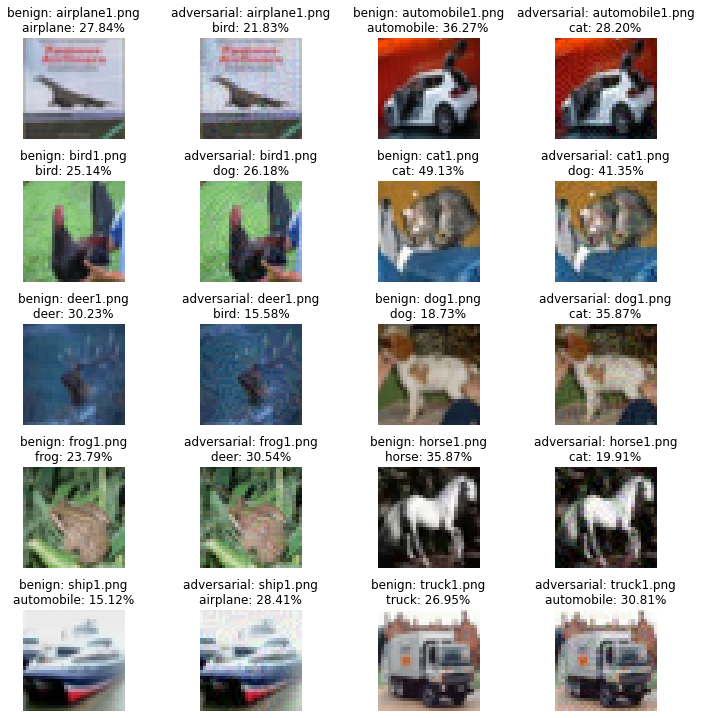

In [15]:
import matplotlib.pyplot as plt

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

model = ptcv_get_model('resnet110_cifar10', pretrained=True).to(device)
loss_fn = nn.CrossEntropyLoss()

plt.figure(figsize=(10, 20))
cnt = 0
for i, cls_name in enumerate(classes):
    path = f'{cls_name}/{cls_name}1.png'
    # benign image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./data/{path}')
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'benign: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
    # adversarial image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./ensemble-mifgsm/{path}')
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'adversarial: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
plt.tight_layout()
plt.show()

## Report Question
* Make sure you follow below setup: the source model is "resnet110_cifar10", applying the vanilla fgsm attack on `dog2.png`. You can find the perturbed image in `fgsm/dog2.png`.

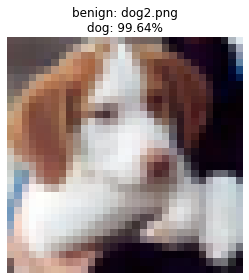

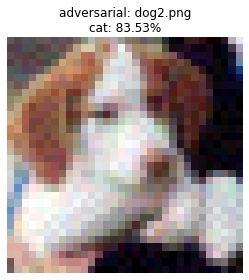

In [36]:
# original image
path = f'dog/dog2.png'
im = Image.open(f'./data/{path}')
logit = model(transform(im).unsqueeze(0).to(device))[0]
predict = logit.argmax(-1).item()
prob = logit.softmax(-1)[predict].item()
plt.title(f'benign: dog2.png\n{classes[predict]}: {prob:.2%}')
plt.axis('off')
plt.imshow(np.array(im))
plt.tight_layout()
plt.show()

# adversarial image 
im = Image.open(f'./fgsm/{path}')
logit = model(transform(im).unsqueeze(0).to(device))[0]
predict = logit.argmax(-1).item()
prob = logit.softmax(-1)[predict].item()
plt.title(f'adversarial: dog2.png\n{classes[predict]}: {prob:.2%}')
plt.axis('off')
plt.imshow(np.array(im))
plt.tight_layout()
plt.show()


## Passive Defense - JPEG compression
JPEG compression by imgaug package, compression rate set to 70

Reference: https://imgaug.readthedocs.io/en/latest/source/api_augmenters_arithmetic.html#imgaug.augmenters.arithmetic.JpegCompression

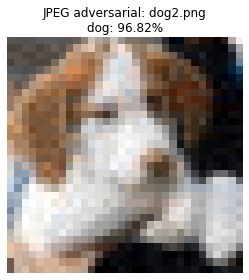

In [41]:
import imgaug.augmenters as iaa

# pre-process image
x = transforms.ToTensor()(im)*255
x = x.permute(1, 2, 0).numpy()
compressed_x = x.astype(np.uint8)

# TODO: use "imgaug" package to perform JPEG compression (compression rate = 70)
seq = iaa.Sequential([
        iaa.JpegCompression(compression=(70, 70))
    ])
compressed_x = seq(images=compressed_x)

logit = model(transform(compressed_x).unsqueeze(0).to(device))[0]
predict = logit.argmax(-1).item()
prob = logit.softmax(-1)[predict].item()
plt.title(f'JPEG adversarial: dog2.png\n{classes[predict]}: {prob:.2%}')
plt.axis('off')


plt.imshow(compressed_x)
plt.tight_layout()
plt.show()